<a href="https://colab.research.google.com/github/wincmoriya/pytorch-handson/blob/main/CNN%E3%81%AB%E3%82%88%E3%82%8BCIFAR10%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

## 前処理

In [6]:
transform = transforms.Compose([
                                # 画像をTensorクラスに変える、チャネルファーストに変換する
                                transforms.ToTensor(),
                                # RGBのチャネルごとに画像全体の平均値0.5, 標準偏差0.5になるように正規化
                                transforms.Normalize((0.5,), (0.5,))
])

# 学習用データセット
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
# 検証用のデータセット, 学習済みでない画像1万枚使用
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
# CIFAR10で扱われる10個の分類を定義しておく
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [9]:
# datasetをdataLoaderに与える
# batch_size　＝ ミニバッチ, 学習時には読み込みをランダムに「するためにshuffleする
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 同様に検証データローダーも作成, 検証時にシャッフルする必要がないのでFalse
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

### iterを使って要素取得
iter()はリストやタプルなど複数の要素を持つデータに対して、イテレータに変換することで要素を最初から順番に取り出すことができる機能

In [10]:
# data_loaderから画像とラベルを取得してみる
data_iter = iter(train_dataloader)

In [11]:
# 1つだけ取得する
imgs, labels = data_iter.next()

In [14]:
# 最初の画像を見るとラベル番号6(カエル)であることがわかる
labels

tensor([6, 3, 1, 1, 2, 7, 3, 2, 2, 6, 5, 1, 9, 5, 8, 5, 6, 3, 0, 1, 8, 2, 9, 4,
        5, 4, 5, 8, 0, 9, 5, 0])

In [16]:
# 画像のサイズを確認
# torch.Size([ミニバッチ数, チャネル, 高さ, 横])->チャネルファーストになっている
imgs.size()

torch.Size([32, 3, 32, 32])

In [17]:
img = imgs[0]

In [18]:
# Tensor -> 画像にするためにチャネルラストにする
img_permute = img.permute(1, 2, 0)

In [19]:
# 画像の明るさを調整する
img_permute = 0.5 * img_permute + 0.5

## np.clip()
配列内の値をクリップ(制限)する。<br>
たとえば、 [0, 1] 間隔が指定されている場合、0より小さい値は0になり、1より大きい値は1になる。

In [20]:
# 0から1の値にクリップする
img_permute = np.clip(img_permute, 0, 1)

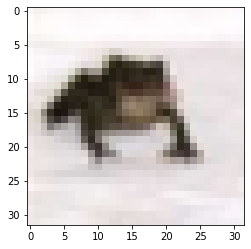

In [22]:
# ラベル番号6のカエルが表示されている
plt.imshow(img_permute)

## CNNのクラス定義

In [24]:
class CNN(nn.Module):
    # num_classesは今回は10
    def __init__(self, num_classes):
        # 最初は32×32の画像
        super().__init__()
        self.features = nn.Sequential(
            # 1層目 32×32
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 2層目 16×16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 3層目 8×8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 4層目 4×4
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        # VGG16でも全結合層があったようにここでも設ける
        # 1次元のベクトルで渡す必要がある
        # 4層目が現在4×4×128になっているので
        self.classifier = nn.Linear(in_features=4*4*128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        # 出力は4*4*128のチャネルを持った画像
        # このままだとclassifierに入力できないので1次元にベクトル化をする
        # size(0)はバッチ数で32、第二引数を-1にすることで残りを自動で押し込む
        # つまりC*H*W -> 4*4*128のベクトルになる
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

#### Conv2d(畳み込み)
* 第1引数はその入力のチャネル数 -> 今回はRGBの3
* 第2引数は畳み込み後のチャネル数 -> 今回は64
* 第3引数は畳み込みをするための正方形フィルタ(カーネルとも言う)の1辺のサイズ
* ※2マスずつ収縮しちゃうのでpaddingを与えるときに2を設定する
    * そうすると画像が縮まない

#### MaxPooling
「nn.MaxPool2d(2, stride=2)」はpooling用でこのパラメータの場合データサイズが半分になるような処理をする(サイズの小数点以下は切り下げられる).
32×32の画像が16×16の半分になる

## モデルの作成

In [27]:
model = CNN(10)
# GPUに送る
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [31]:
# 損失関数とオプティマイザを設定する
criterion = nn.CrossEntropyLoss()
# weight_decay：重みが大きくなりすぎないようにL2正則化する
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [34]:
# 学習のループを描いていく
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    #
    # 学習trainのループ
    #
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # outputでモデルの予測値を出す
        output = model(imgs)
        loss = criterion(output, labels)
        # 誤差逆伝播
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        # 重みの更新
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

    # 検証validationのループ
    val_running_loss = 0
    val_running_acc = 0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, \
        val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 0.7459864753297866, acc: 0.7381237745285034,         val loss: 0.7946126963764715, val acc: 0.7241413593292236
epoch: 1, loss: 0.6326755042821264, acc: 0.7793106436729431,         val loss: 0.8137038385334868, val acc: 0.7220447063446045
epoch: 2, loss: 0.552127075935127, acc: 0.8075215816497803,         val loss: 0.7307430228676659, val acc: 0.7522963285446167
epoch: 3, loss: 0.4913023362271082, acc: 0.829314649105072,         val loss: 0.7354019251399146, val acc: 0.7594848275184631
epoch: 4, loss: 0.4363166981270049, acc: 0.845149576663971,         val loss: 0.735182000330081, val acc: 0.7622803449630737
epoch: 5, loss: 0.39327377119767154, acc: 0.8631637692451477,         val loss: 0.724114790035132, val acc: 0.7606828808784485
epoch: 6, loss: 0.3525813831039064, acc: 0.8748200535774231,         val loss: 0.7570352822827836, val acc: 0.763877809047699
epoch: 7, loss: 0.32097979285352063, acc: 0.8860964775085449,         val loss: 0.767653460795887, val acc: 0.762779

# まとめ
* 学習大体10分くらいかかる
* 訓練データ
    * 損失関数が順調に下がってきている
    * 精度も92%くらいまで上がっている
* 検証データ
    * 損失関数が途中まで良かったが後半上がってきている
    * それに伴って精度が低くなっている
    * 過学習してしまっている

* 過学習を抑えるための手段としてデータ拡張がある

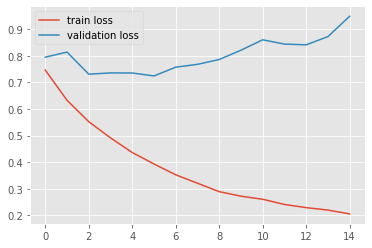

In [35]:
# グラフを見てみる
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

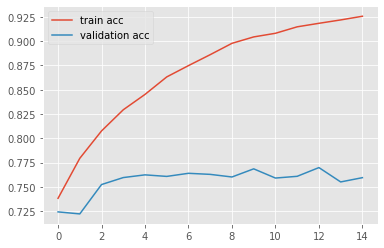

In [36]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()